In [ ]:
import os
import sys
import numpy as np
import numpy.typing as npt
from typing import List, Tuple

from helpers import LowHighDemoSDE
import python_modules.Server as Server

In [28]:
import gymnasium as gym
from gymnasium import spaces

In [29]:
class SimulationEnv(gym.Env):
    def initialize_book(self):
        t = self.simulation.get_t()
        dt = self.simulation.get_dt()
        ORDER_COUNT = self.SDE.get_order_count(t, dt)
    
        price_distribution = self.rng.uniform(0.75, 1.0, size=ORDER_COUNT)
        volume_distribution = self.rng.integers(self.ORDER_SIZE_MIN, self.ORDER_SIZE_MAX, ORDER_COUNT)
        target = self.SDE.get_stock_price(t, dt)
        volatility = self.SDE.get_volatility(t, dt)
        SPREAD = self.SDE.get_spread(t, dt)
        HALF_SPREAD = SPREAD / 2

        bid_top_price = round(target - HALF_SPREAD, 2)
        bid_bottom_price = round(bid_top_price - 0.5 * volatility * bid_top_price, 2)
        bid_prices: List[float] = list(bid_top_price * price_distribution + bid_bottom_price * (1.0 - price_distribution))
        bids = [(Server.OrderSide.BID, price, volume_distribution[i]) for i, price in enumerate(bid_prices)]
        
        ask_bottom_price = round(target + HALF_SPREAD, 2)
        ask_top_price = round(ask_bottom_price + 0.5 * volatility * ask_bottom_price, 2)
        ask_prices: List[float] = list(ask_bottom_price * price_distribution + ask_top_price * (1.0 - price_distribution))
        asks = [(Server.OrderSide.ASK, price, volume_distribution[i]) for i, price in enumerate(ask_prices)]

        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        self.rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            self.simulation.direct_insert_limit_order(self.anon_id, self.stock_id, side, round(price, 2), volume)
            pass
        pass
    
    def do_liquidity_trading(self):
        t = self.simulation.get_t()
        dt = self.simulation.get_dt()
        ORDER_COUNT = self.SDE.get_order_count(t, dt)
        orders_ANON = list(self.simulation.get_all_open_user_orders(self.anon_id, self.stock_id))
        
        # remove some percent of ANON orders
        if (k := int(len(orders_ANON) * self.REMOVAL_PERCENTAGE)) > 0:
            orders_to_remove = list(self.rng.choice(a=orders_ANON, size=k, replace=False))
            for order_id in orders_to_remove:
                self.simulation.submit_cancel_order(self.anon_id, self.stock_id, order_id)
                pass
            pass
        
        top_bid = self.simulation.get_top_bid(self.stock_id)
        top_ask = self.simulation.get_top_ask(self.stock_id)
        
        top_bid_price = top_bid.price
        top_ask_price = top_ask.price
        
        bid_prices = self.SDE.generate_bid_price_array(top_bid_price, t, dt)
        bid_quantities = self.rng.integers(self.ORDER_SIZE_MIN, self.ORDER_SIZE_MAX, size=ORDER_COUNT)
        bids = [(Server.OrderSide.BID, price, bid_quantities[i]) for i, price in enumerate(bid_prices)]
        
        ask_prices = self.SDE.generate_ask_price_array(top_ask_price, t, dt)
        ask_quantities = self.rng.integers(self.ORDER_SIZE_MIN, self.ORDER_SIZE_MAX, size=ORDER_COUNT) 
        asks = [(Server.OrderSide.ASK, price, ask_quantities[i]) for i, price in enumerate(ask_prices)]
        
        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        self.rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            self.simulation.submit_limit_order(self.anon_id, self.stock_id, side, round(price, 2), volume)
            pass
        pass
    
    def get_portfolio_value(self):
        portfolio = self.simulation.get_user_portfolio(self.agent_id)
        stock_pos = portfolio[self.stock_id]
        currency_pos = portfolio[self.currency_id]
        top_bid = self.simulation.get_top_bid(self.stock_id).price
        top_ask = self.simulation.get_top_ask(self.stock_id).price
        stock_value = stock_pos * (top_bid if stock_pos < 0 else top_ask)
        return currency_pos + stock_value
    
    def __init__(self):
        super().__init__()
        self.rng = np.random.default_rng()
        self.SDE = LowHighDemoSDE(self.rng)
        
        self.ORDER_SIZE_MIN = 1
        self.ORDER_SIZE_MAX = 5
        self.REMOVAL_PERCENTAGE = 0.10 # The "liquidity" traders (aka "anon") will cancel this percent of their orders every step
        
        self.currency = Server.GenericSecurities.GenericCurrency("CAD")
        self.stock = Server.GenericSecurities.GenericStock("STOCK", "CAD")
        self.simulation = Server.GenericSimulation({ "CAD": self.currency, "STOCK": self.stock }, 1.0, 1000) 
        self.currency_id = self.simulation.get_security_id("CAD")
        self.stock_id = self.simulation.get_security_id("STOCK")
        
        self.agent_id = self.simulation.add_user("AGENT")
        self.anon_id = self.simulation.add_user("ANON")
        
        self.MAX_POSITION = 20
        
        self.initialize_book()

        self.action_space = spaces.Discrete(3) # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.simulation.reset_simulation()
        self.initialize_book()
        self.prev_portfolio_value = self.get_portfolio_value()
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        # Cancel any previous agent orders if applicable
        tick = self.simulation.get_tick()
        agent_portfolio = self.simulation.get_user_portfolio(self.agent_id)
        agent_stock_position = agent_portfolio[self.stock_id]
        agent_currency_position = agent_portfolio[self.currency_id]
        
        # The agent always gets to go first
        orders = self.simulation.get_all_open_user_orders(self.agent_id, self.stock_id)
        for order_id in orders:
            self.simulation.submit_cancel_order(self.agent_id, self.stock_id, order_id)

        top_ask = self.simulation.get_top_ask(self.stock_id)
        top_bid = self.simulation.get_top_bid(self.stock_id)
        
        if action == 1 and agent_stock_position < self.MAX_POSITION:
            # buy one unit at the ask
            self.simulation.submit_limit_order(self.agent_id, self.stock_id, Server.OrderSide.BID, top_ask.price, 1)

        elif action == 2 and agent_stock_position > -self.MAX_POSITION:
            # sell one unit at the bid
            self.simulation.submit_limit_order(self.agent_id, self.stock_id, Server.OrderSide.ASK, top_bid.price, 1)


        # Enter liquidity orders
        # We already initialize the book on tick == 0 (look at reset and __init__)
        if tick != 0:
            self.do_liquidity_trading()
            pass

        result = self.simulation.do_simulation_step()

        # market positions to market
        # On the last step, the the `Server` library automatically converts the remaining stock position into currency        
        portfolio_value = self.get_portfolio_value()
        
        # Compute reward as change in portfolio value
        reward = portfolio_value - self.prev_portfolio_value
        self.prev_portfolio_value = portfolio_value

        terminated = not result.has_next_step
        if terminated:
            reward += portfolio_value * 5.0
        obs = self._get_obs()
        return obs, reward, terminated, False, {}
    
    def _get_obs(self):
        top_bid_price = self.simulation.get_top_bid(self.stock_id).price
        top_ask_price = self.simulation.get_top_ask(self.stock_id).price
        mid_price = 0.5 * (top_bid_price + top_ask_price)
        stock_position = self.simulation.get_user_portfolio(self.agent_id)[self.stock_id]
        max_tick = self.simulation.get_N()
        tick = self.simulation.get_tick()

        return np.array([
            top_bid_price,
            top_ask_price,
            stock_position,
            mid_price,
            (max_tick - tick) / max_tick,
        ], dtype=np.float32)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback

def make_env():
    def _init():
        env = SimulationEnv()
        return Monitor(env)  # for logging
    return _init

env = SubprocVecEnv([make_env() for _ in range(8)])

model = PPO("MlpPolicy", env, verbose=0, device="cpu")
model.learn(total_timesteps=4_000_000)

# Save model
model.save("gymnasium_v01_model")


c:\Users\Emu\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [36]:
import matplotlib.pyplot as plt

def evaluate_agent(model, env: SimulationEnv):
    obs, _ = env.reset()
    done = False

    mid_prices = []
    stock_positions = []
    currency_positions = []
    portfolio_values = []
    ticks = []

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        tick = env.simulation.get_tick()
        ticks.append(tick)

        # Record values
        bid = env.simulation.get_top_bid(env.stock_id).price
        ask = env.simulation.get_top_ask(env.stock_id).price
        mid = 0.5 * (bid + ask)
        mid_prices.append(mid)

        portfolio = env.simulation.get_user_portfolio(env.agent_id)
        stock_pos = portfolio[env.stock_id]
        currency_pos = portfolio[env.currency_id]
        stock_value = stock_pos * (bid if stock_pos < 0 else ask)
        total_value = currency_pos + stock_value

        stock_positions.append(stock_pos)
        currency_positions.append(currency_pos)
        portfolio_values.append(total_value)

    print(f"Final portfolio value: {total_value:.2f}")

    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(ticks, mid_prices, color="blue")
    axs[0].set_ylabel("Mid Price")

    axs[1].plot(ticks, stock_positions, color="green")
    axs[1].set_ylabel("Stock Position")

    axs[2].plot(ticks, currency_positions, color="orange")
    axs[2].set_ylabel("Currency Position")

    axs[3].plot(ticks, portfolio_values, color="purple")
    axs[3].set_ylabel("Portfolio Value")
    axs[3].set_xlabel("Tick")

    plt.tight_layout()
    plt.show()


Final portfolio value: 186.34


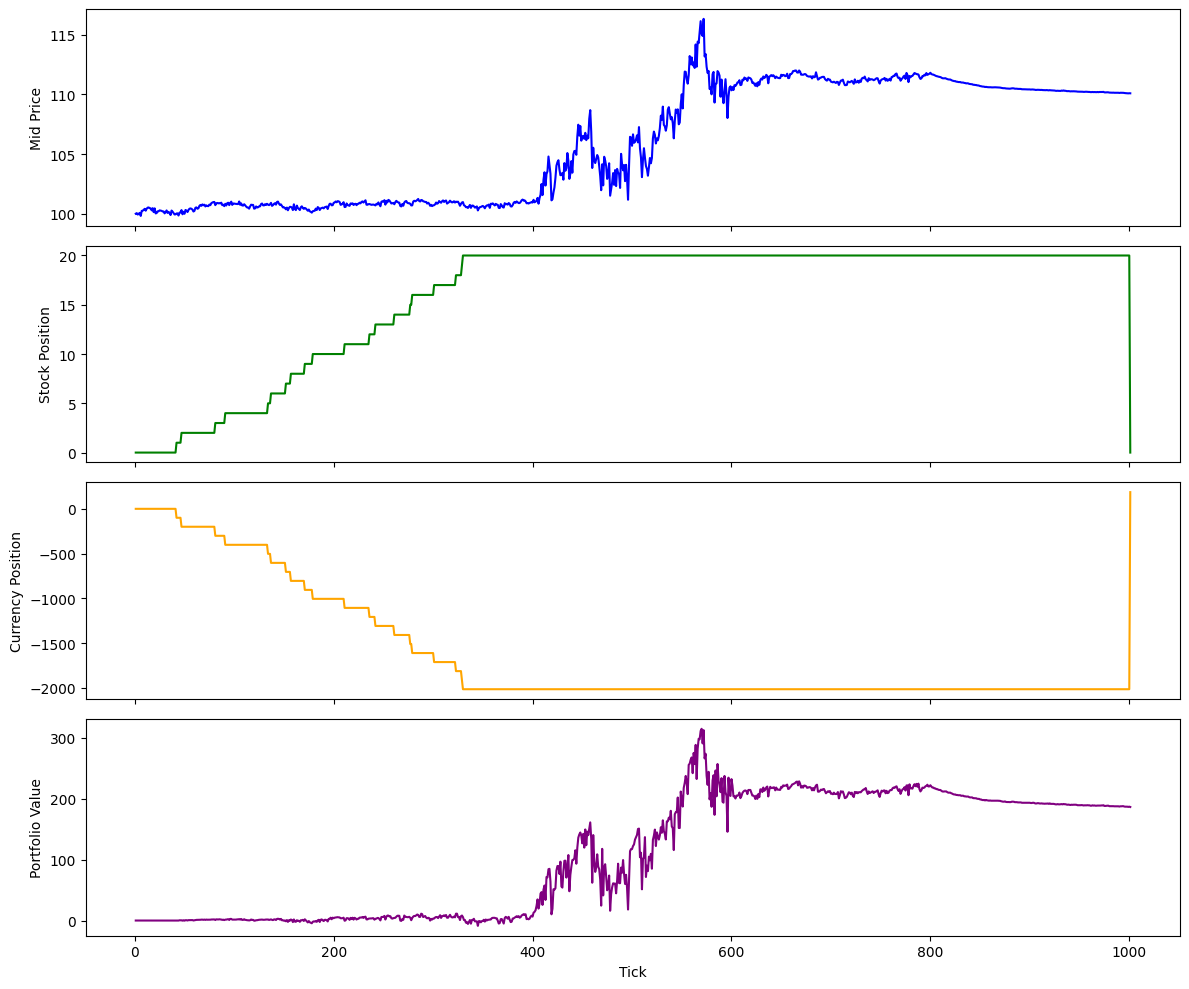

In [40]:
evaluate_agent(model, SimulationEnv())
